## Predicting the Sentiment of Yelp reviews

### Abstract

Five-week final project for my General Assmebly immersive programmed. Project involved using the [Yelp](https://www.yelp.com/dataset) dataset to classify restaurant reviews as positive or negative based on their content. I used a number of different natural language processing (NLP) techniques including, stemming, count vectorising and term frequency - indirect document frequency (TFIDF), along with Logistic Regression modelling. The result was an extremely accurate model (accuracy and recall scores of 0.95) which I could then use to analyse reviews from individual restaurants to understand what aspects matter most to people.

---

#### Setting up connection local DB for storing review data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlalchemy

In [2]:
db_user = 'user'
db_password = ''
db_host = 'localhost'
db_port = 5432
database = 'user'

conn_postgres = f'postgres://{db_user}:{db_password}@{db_host}:{db_port}'

In [3]:
# create an sqlalchemy connection
engine = sqlalchemy.engine.create_engine(conn_postgres)
# connect using sqlalchemy
connection = engine.connect()

---

## Data Loading (JSONs) <a id='data_loading'></a>

### Load business data

In [3]:
biz = pd.read_json("~/Documents/Datasets/yelp_dataset/yelp_academic_dataset_business.json", lines=True)

In [23]:
biz.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None


In [41]:
biz.shape

(209393, 14)

In [18]:
biz.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [35]:
biz['business_id'] = biz['business_id'].astype('str')
biz['attributes'] = biz['attributes'].astype('str')
biz['categories'] = biz['categories'].astype('str')
biz['hours'] = biz['hours'].astype('str')

In [36]:
biz.to_sql(name='yelp_business', con=engine, if_exists = 'replace', index=False)
connection.execute('commit')

---

### Load tips data

In [43]:
tip = pd.read_json("~/Documents/Datasets/yelp_dataset/yelp_academic_dataset_tip.json", lines=True)

In [44]:
tip.head(3)

,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26 18:20:08,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15 22:26:45,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18 22:03:42,0


In [45]:
tip.shape

(1320761, 5)

In [46]:
tip.dtypes

user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object

In [47]:
tip['business_id'] = tip['business_id'].astype('str')
tip['user_id'] = tip['user_id'].astype('str')

In [48]:
tip.to_sql(name='yelp_tips', con=engine, if_exists = 'replace', index=False)
connection.execute('commit')

---

### Load check-in data

In [52]:
cin = pd.read_json("~/Documents/Datasets/yelp_dataset/yelp_academic_dataset_checkin.json", lines=True)

In [53]:
cin.head(3)

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."


In [54]:
cin.shape

(175187, 2)

In [55]:
cin.dtypes

business_id    object
date           object
dtype: object

In [57]:
cin['business_id'] = cin['business_id'].astype('str')
cin['date'] = cin['date'].astype('str')

In [58]:
cin.to_sql(name='yelp_check_ins', con=engine, if_exists = 'replace', index=False)
connection.execute('commit')

---

### Load user data

In [71]:
user_files = ['users.ab', 'users.ac', 'users.ad', 'users.ae']

In [64]:
users = pd.read_json("~/Documents/Datasets/yelp_dataset/users.aa", lines=True)

In [66]:
users.head(3)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1


In [67]:
users.shape

(393741, 22)

In [68]:
users.dtypes

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

In [69]:
users['user_id'] = users['user_id'].astype('str')
users['elite'] = users['elite'].astype('str')
users['friends'] = users['friends'].astype('str')

In [70]:
users.to_sql(name='yelp_users', con=engine, if_exists = 'replace', index=False)
connection.execute('commit')

In [76]:
for file in tqdm(user_files):
    path = "~/Documents/Datasets/yelp_dataset/" + file
    users = pd.read_json(path, lines=True)
    
    users['user_id'] = users['user_id'].astype('str')
    users['elite'] = users['elite'].astype('str')
    users['friends'] = users['friends'].astype('str')
    
    users.to_sql(name='yelp_users', con=engine, if_exists = 'append', index=False)
    connection.execute('commit')

---

### Load review data

In [77]:
review_files = ['reviews.ab', 
                'reviews.ac', 
                'reviews.ad', 
                'reviews.ae', 
                'reviews.af', 
                'reviews.ag', 
                'reviews.ah', 
                'reviews.ai', 
                'reviews.aj']

In [78]:
reviews = pd.read_json("~/Documents/Datasets/yelp_dataset/reviews.aa", lines=True)

In [79]:
reviews.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11


In [80]:
reviews.shape

(802113, 9)

In [81]:
reviews.dtypes

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object

In [82]:
reviews['review_id'] = reviews['review_id'].astype('str')
reviews['user_id'] = reviews['user_id'].astype('str')
reviews['business_id'] = reviews['business_id'].astype('str')

In [83]:
reviews.to_sql(name='yelp_reviews', con=engine, if_exists = 'replace', index=False)
connection.execute('commit')

In [89]:
for file in tqdm(review_files):
    path = "~/Documents/Datasets/yelp_dataset/" + file
    reviews = pd.read_json(path, lines=True)
    
    reviews['review_id'] = reviews['review_id'].astype('str')
    reviews['user_id'] = reviews['user_id'].astype('str')
    reviews['business_id'] = reviews['business_id'].astype('str')

    reviews.to_sql(name='yelp_reviews', con=engine, if_exists = 'append', index=False)
    connection.execute('commit')

100%|██████████| 9/9 [31:55<00:00, 212.87s/it]


---

### Check data - read data from Postgres

In [84]:
data = pd.read_sql(sql='yelp_reviews', con=engine)

In [85]:
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [86]:
data.shape

(802113, 9)

---

### Check the language of reviews

In [4]:
from langdetect import detect, DetectorFactory, detect_langs
DetectorFactory.seed = 0

In [17]:
for data in tqdm(pd.read_sql(sql='select review_id, text from yelp_reviews_filtered where stars=3', con=engine, chunksize=50000)):
    langs = []
    detected_langs = []
    
    for idx, row in data.iterrows():
        try:
            langs.append(detect(row['text']))
            detected_langs.append(str(detect_langs(row['text'])))
        except:
            print(row)
            langs.append('fail')
            detected_langs.append('fail')
            continue
    
    lang = pd.DataFrame({'review_id': data['review_id'], 'lang': langs, 'detected_langs': detected_langs})
#     print(lang)
    lang.to_sql(name='yelp_reviews_lang', con=engine, if_exists ='append', index=False)
    connection.execute('commit')

1it [01:05, 65.23s/it]


---

## Feature Creation

### 1. Load sample data into a dataframe

In [5]:
# function to return a sample from the data
def get_sample(sample_size=100):
    query = """
            with reviews_1 as (
            select review_id, stars, text
            from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75) 
            where stars = 1
            limit """ + str(sample_size) + """
            )
            , reviews_2 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 2
                limit """ + str(sample_size) + """
            )
            , reviews_4 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 4
                limit """ + str(sample_size) + """
            )
            , reviews_5 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 5
                limit """ + str(sample_size) + """
            )

            select *
            from reviews_1
            union
            select *
            from reviews_2
            union
            select *
            from reviews_4
            union
            select *
            from reviews_5 
            """

    df = pd.read_sql(con=engine, sql=query)
    df['target'] = df.stars.apply(lambda x: (x > 3)*1)

    return df.copy()

In [5]:
df = get_sample(500)

In [6]:
df.shape

(2000, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   2000 non-null   int64 
 1   text    2000 non-null   object
 2   target  2000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 47.0+ KB


In [8]:
df.head()

,stars,text,target
0,2,First time checking this place out tonight- no...,0
1,4,"Oh, those pepperoni rolls!!!\n\nI've had nothi...",1
2,1,This store and its employees are the most unfr...,0
3,4,Great customer service and has become one of m...,1
4,4,A vegetarian in a steakhouse? Who would have t...,1


In [9]:
df.stars.value_counts()

5    500
4    500
2    500
1    500
Name: stars, dtype: int64

### 2. Setup Pipeline

In [17]:
import string
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [18]:
punc = string.punctuation + '\n\t'
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'

In [21]:
# custom pre-processing class for tokenizing, stop word removal, case correction and stemming
class JobPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, punc=None, stopw=None):
        self.punctuation = punc
        self.stop_words = stopw
        self.stemmer = PorterStemmer()
    
    def _strip_punctuation(self, X):
        X = X.str.translate(str.maketrans('', '', self.punctuation))
        return X
    
    
    def _to_lowercase(self, X):
        X = X.str.lower()
        return X
    
    
    def _tokenise(self, s):
        return s.split()
    
    
    def _remove_stop_words(self, X):
        X = X.apply(lambda x: ' '.join([l for l in self._tokenise(x) if l not in self.stop_words]))
        return X
    
    
    def _stem_words(self, X):
        X = X.apply(lambda x: ' '.join([self.stemmer.stem(l) for l in self._tokenise(x)]))
        return X
    
    
    def transform(self, X, *args):
        
        # strip punctuation
        X = self._strip_punctuation(X)
        
        # convert text to lowercase
        X = self._to_lowercase(X)
        
        # remove stop words
        X = self._remove_stop_words(X)
        
        # stem words
        X = self._stem_words(X) # lemmatisation instead?

        return X
        
    
    def fit(self, X, *args):
        return self

### 3. Identify optimal settings for Count Vecotorizing & TFIDF

In [22]:
import itertools as it

In [23]:
pipe_params = {
    'pre__stopw': [None, stopwords.words('english')],
    'cv__min_df': [1, 3, 5],
    'cv__binary': [False, True],
    'cv__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__use_idf': [False, True]
}

test_combos = list(it.product(*[pipe_params[param] for param in pipe_params]))
# print(list(test_combos))

In [24]:
# setup test pipeline
pipe_test = Pipeline([
    ('pre', JobPreprocessor()),
    ('cv', CountVectorizer(strip_accents="unicode", ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(solver='liblinear', penalty='l2'))
])

In [17]:
# setup test sample
test_sample = get_sample(5000)
X_test = test_sample['text']
y_test = test_sample['target']

In [19]:
test_res = pd.read_csv('pipe_param_results.csv')

In [20]:
test_res.shape

(288, 7)

In [21]:
test_res

,params,samples,features,accuracy,recall_0,recall_1,avg_score
0,"(None, 1, False, (1, 1), False)",400,4362,0.791019,0.821564,0.760476,0.791020
1,"(None, 1, False, (1, 1), True)",400,4491,0.845277,0.839968,0.850585,0.845277
2,"(None, 1, False, (1, 2), False)",400,28533,0.792469,0.814963,0.769977,0.792470
3,"(None, 1, False, (1, 2), True)",400,29844,0.850428,0.881976,0.818882,0.850429
4,"(None, 1, False, (1, 3), False)",400,64704,0.783768,0.805561,0.761976,0.783768
...,...,...,...,...,...,...,...
283,"(5, True, (1, 1), True)",28000,10627,0.940547,0.943994,0.937100,0.940547
284,"(5, True, (1, 2), False)",27997,77116,0.939997,0.945895,0.934100,0.939997
285,"(5, True, (1, 2), True)",28000,78066,0.953548,0.957896,0.949200,0.953548
286,"(5, True, (1, 3), False)",28000,136222,0.941097,0.945495,0.936700,0.941097


In [126]:
# setup results dataframe
# test_res_columns = ['params', 'samples', 'features', 'accuracy', 'recall_0', 'recall_1']
# test_res = pd.DataFrame(columns=test_res_columns)

# test params
for sample in [7000]:
    for combo in tqdm(test_combos):
    
        df = get_sample(sample)

        X = df['text'].copy()
        y = df['target'].copy()

        res = []

        pipe_test.set_params(pre__punc = punc,
                        pre__stopw = combo[0],
                        cv__min_df = combo[1], 
                        cv__binary = combo[2],
                        cv__ngram_range = combo[3],
                        tfidf__use_idf = combo[4])

        # append pipeline parameters
        if combo[0] != None:
            res.append(combo[1:])
        else:
            res.append(combo)
        
        # append sample size
        res.append(X.shape[0])

        pipe_test.fit(X, y)

        # append number of CV feature number
        res.append(len(pipe_test['cv'].get_feature_names()))
        
        # calculate accuracy and recall scores
        predicted = pipe_test.predict(X_test)
        res.append(accuracy_score(y_test, predicted))
        res.append(recall_score(y_test, predicted, pos_label=0, average='binary'))
        res.append(recall_score(y_test, predicted, pos_label=1, average='binary'))

        # append results to test results
        test_res = test_res.append(pd.Series(res, index=test_res.columns), ignore_index=True)

100%|██████████| 72/72 [1:53:30<00:00, 94.59s/it] 


In [127]:
test_res.shape # should be 288, 6

(288, 6)

In [128]:
test_res

,params,samples,features,accuracy,recall_0,recall_1
0,"(None, 1, False, (1, 1), False)",400,4362,0.791019,0.821564,0.760476
1,"(None, 1, False, (1, 1), True)",400,4491,0.845277,0.839968,0.850585
2,"(None, 1, False, (1, 2), False)",400,28533,0.792469,0.814963,0.769977
3,"(None, 1, False, (1, 2), True)",400,29844,0.850428,0.881976,0.818882
4,"(None, 1, False, (1, 3), False)",400,64704,0.783768,0.805561,0.761976
...,...,...,...,...,...,...
283,"(5, True, (1, 1), True)",28000,10627,0.940547,0.943994,0.937100
284,"(5, True, (1, 2), False)",27997,77116,0.939997,0.945895,0.934100
285,"(5, True, (1, 2), True)",28000,78066,0.953548,0.957896,0.949200
286,"(5, True, (1, 3), False)",28000,136222,0.941097,0.945495,0.936700


In [129]:
# test_res.to_csv('pipe_param_results.csv', index=False)

In [13]:
test_res = pd.read_csv('pipe_param_results.csv')

In [14]:
test_res.shape

(288, 7)

In [24]:
# test_res['avg_score'] = test_res[['accuracy', 'recall_0', 'recall_1']].apply('mean', axis=1)
# test_res.to_csv('pipe_param_results.csv', index=False)

In [15]:
test_res.sort_values(by='avg_score', ascending=False).head(20)

,params,samples,features,accuracy,recall_0,recall_1,avg_score
275,"(3, True, (1, 3), True)",27999,254778,0.954948,0.962296,0.9476,0.954948
251,"(None, 5, True, (1, 3), True)",27996,136033,0.954148,0.959696,0.9486,0.954148
239,"(None, 3, True, (1, 3), True)",27998,255915,0.954048,0.959996,0.9481,0.954048
273,"(3, True, (1, 2), True)",27999,129179,0.953998,0.959396,0.9486,0.953998
285,"(5, True, (1, 2), True)",28000,78066,0.953548,0.957896,0.9492,0.953548
287,"(5, True, (1, 3), True)",27998,136519,0.953248,0.958196,0.9483,0.953248
215,"(5, True, (1, 3), True)",20000,98505,0.953198,0.959096,0.9473,0.953198
179,"(None, 5, True, (1, 3), True)",19998,98582,0.953098,0.958096,0.9481,0.953098
237,"(None, 3, True, (1, 2), True)",27998,128472,0.952998,0.958796,0.9472,0.952998
203,"(3, True, (1, 3), True)",19998,187556,0.952398,0.958096,0.9467,0.952398


Based on the above results, it seems like params (No Stop Words, 5, True, (1, 2), True) would be good choices. It results in less features than other settings, while also scoring highly. 

A future improvement could be test if increasing the min_df param results in good scores. For now, I will not do this as I need to move and I can test a similar strategy using max_features.

---

### 4. Is dimensionality reduction worthwhile? - Sparse Matix vs. Truncated SVD vs. Max Features

In [16]:
# import sample to test on 
df = get_sample(5000)

# # Define predictors and target
X = df['text'].copy()
y = df['target'].copy()

In [32]:
pipe = Pipeline([
    ('pre', JobPreprocessor()),
    ('cv', CountVectorizer(strip_accents="unicode")),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=3000))
])

In [33]:
pipe.set_params(pre__punc = punc,
                pre__stopw = stopwords.words('english'),
                cv__min_df = 5, 
                cv__binary = True,
                cv__ngram_range = (1,2),
                tfidf__use_idf = True)

Pipeline(steps=[('pre',
                 JobPreprocessor(punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t',
                                 stopw=['i', 'me', 'my', 'myself', 'we', 'our',
                                        'ours', 'ourselves', 'you', "you're",
                                        "you've", "you'll", "you'd", 'your',
                                        'yours', 'yourself', 'yourselves', 'he',
                                        'him', 'his', 'himself', 'she', "she's",
                                        'her', 'hers', 'herself', 'it', "it's",
                                        'its', 'itself', ...])),
                ('cv',
                 CountVectorizer(binary=True, min_df=5, ngram_range=(1, 2),
                                 strip_accents='unicode')),
                ('tfidf', TfidfTransformer())])

In [19]:
X_tf = pipe.fit_transform(X)

In [20]:
# Get the most important pieces of information
# print("Number of principal components:\t\t", pipe['svd'].n_components)
# print("Explained variance:\t\t\t", np.round(pipe['svd'].explained_variance_, 3))
# print("Explained variance ratio:\t\t", np.round(pipe['svd'].explained_variance_ratio_, 3))
# print("Cumulative explained variance ratio:\t", np.round(np.cumsum(pipe['svd'].explained_variance_ratio_), 3))

Number of principal components:		 3000


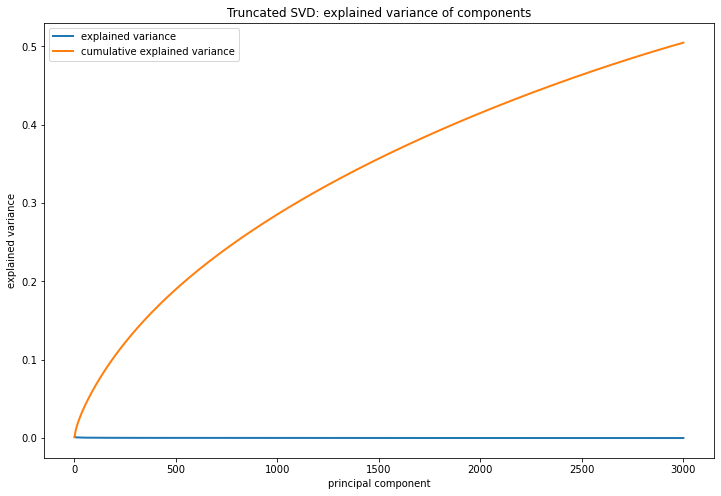

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
x_values = range(1, pipe['svd'].n_components+1)
ax.plot(x_values, pipe['svd'].explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(pipe['svd'].explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Truncated SVD: explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.legend()
plt.show()

Using dimensionality reduction will not be useful as each contributes equally (and very little) to the overall variance, so there is no point reducing dimensionality.

Another reason this approach is not beneficial is that it converts the sparse matrix from TFDIF to a dense matrix (values stored for every cell), which will degrade performance wise as the sample size increases.

#### Is limiting the number of features worthwhile?

In [11]:
# define pipeline
pipe_feat = Pipeline([
    ('pre', JobPreprocessor()),
    ('cv', CountVectorizer(strip_accents="unicode")),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(solver='liblinear', penalty='l2'))
])

TypeError: __init__() missing 2 required positional arguments: 'punc' and 'stopw'

In [12]:
pipe_feat.set_params(pre__punc = punc,
                    pre__stopw = stopwords.words('english'),
                    cv__min_df = 5, 
                    cv__binary = True,
                    cv__ngram_range = (1,2),
                    tfidf__use_idf = True)

NameError: name 'pipe_feat' is not defined

In [12]:
# setup test sample
df = get_sample(5000)

# # Define predictors and target
X_test = df['text'].copy()
y_test = df['target'].copy()

In [75]:
# define results dataframe
# feat_test = pd.DataFrame(columns=[['param', 'samples', 'features' ,'accuracy', 'recall_0', 'recall_1']])

In [13]:
feat_test = pd.read_csv('feat_test.csv')

In [16]:
def get_sample_results(pipe, X, y, X_t, feats=None):
    # append results without feature limiting
    res = []

    pipe.set_params(cv__max_features = feats)

    res.append(feats)

    # append sample size
    res.append(X.shape[0])

    pipe.fit(X, y)

    # append number of CV feature number
    res.append(len(pipe['cv'].get_feature_names()))

    # calculate accuracy and recall scores
    predicted = pipe.predict(X_t)
    res.append(accuracy_score(y_test, predicted))
    res.append(recall_score(y_test, predicted, pos_label=0, average='binary'))
    res.append(recall_score(y_test, predicted, pos_label=1, average='binary'))
    
    return res

In [16]:
# for loop going through samples
# test params
for sample in tqdm(np.linspace(30000, 80000, 4)):
    
    df = get_sample(sample)

    X = df['text'].copy()
    y = df['target'].copy()
    

    # append results to test results
#     feat_test = feat_test.append(pd.Series(get_sample_results(pipe_feat, X, y, X_test, None), index=feat_test.columns), ignore_index=True)
#     feat_test = feat_test.append(pd.Series(get_sample_results(pipe_feat, X, y, X_test, 100000), index=feat_test.columns), ignore_index=True)
    feat_test = feat_test.append(pd.Series(get_sample_results(pipe_feat, X, y, X_test, 50000), index=feat_test.columns), ignore_index=True)

100%|██████████| 2/2 [44:44<00:00, 1342.17s/it]


In [19]:
feat_test = pd.read_csv('feat_test.csv')

In [20]:
feat_test['avg_score'] = feat_test[['accuracy', 'recall_0', 'recall_1']].apply('mean', axis=1)

In [21]:
feat_test.sort_values(by='avg_score', ascending=False)

,param,samples,features,accuracy,recall_0,recall_1,avg_score
19,100000.0,319842.0,100000.0,0.96260,0.9668,0.9584,0.96260
18,NaN,319842.0,494452.0,0.96200,0.9672,0.9568,0.96200
15,100000.0,239929.0,100000.0,0.96190,0.9636,0.9602,0.96190
14,NaN,239929.0,392177.0,0.96160,0.9637,0.9595,0.96160
11,100000.0,199955.0,100000.0,0.96100,0.9621,0.9599,0.96100
10,NaN,199955.0,344904.0,0.96095,0.9623,0.9596,0.96095
12,NaN,219937.0,369631.0,0.96060,0.9626,0.9586,0.96060
13,100000.0,219937.0,100000.0,0.96050,0.9622,0.9588,0.96050
17,100000.0,279891.0,100000.0,0.95875,0.9601,0.9574,0.95875
16,NaN,279891.0,443370.0,0.95825,0.9603,0.9562,0.95825


In [22]:
feat_test.to_csv('feat_test.csv', index=False)

Looking at the results above it seems as though limiting the number of features has neglibale impact on model accuracy. This means that after a certain number of features say 100K) additional features provide negilibable benefit. As a result, limiting the feature is definitly something I should do. The further benefit of limiting the the features is that my model will not increase in complexity with increasing more data.

### 5. Optimal pre-processing pipeline

In [10]:
# optimal pipeline
pipe_final = Pipeline([
    ('pre', JobPreprocessor(punc=punc, stopw=stopwords.words('english'))),
    ('cv', CountVectorizer(strip_accents="unicode")),
    ('tfidf', TfidfTransformer())
])

# optimal pipeline parameters
pipe_final.set_params(
                    pre__punc = punc,
                    pre__stopw = stopwords.words('english'),
                    cv__min_df = 5, 
                    cv__binary = True,
                    cv__ngram_range = (1,2),
                    cv__max_features = 100000,
                    tfidf__use_idf = True
)

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(steps=[('pre',
                 JobPreprocessor(punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t',
                                 stopw=['i', 'me', 'my', 'myself', 'we', 'our',
                                        'ours', 'ourselves', 'you', "you're",
                                        "you've", "you'll", "you'd", 'your',
                                        'yours', 'yourself', 'yourselves', 'he',
                                        'him', 'his', 'himself', 'she', "she's",
                                        'her', 'hers', 'herself', 'it', "it's",
                                        'its', 'itself', ...])),
                ('cv',
                 CountVectorizer(binary=True, max_features=100000, min_df=5,
                                 ngram_range=(1, 2), strip_accents='unicode')),
                ('tfidf', TfidfTransformer())])

---

## Modelling

In [10]:
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from time import time

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

In [11]:
def get_freq_words(sparse_counts, columns):

    word_counts = np.ravel(sparse_counts.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)

    return freq_words

### 1. Setup a test / train split 

In [13]:
# create training data
df_train = get_sample(100000)
X_train = df_train['text'].copy()
# transform training set using pipeline
X_train = pipe_final.fit_transform(X_train)
y_train = df_train['target'].copy()

In [14]:
# create test data
df_test = get_sample(50000)
X_test = df_test['text'].copy()
# transform training set using pipeline
X_test = pipe_final.transform(X_test)
y_test = df_test['target'].copy()

Training and test data are randomly sampled from the set of all 1,2,4,5 star. reviews. Reviews are equally-weighted sample to ensure my model is equally good at predicting both positive and negative reviews.

The target is a binary variable indicating if a review was positive (4 or 5 stars) or negative (1 or 2 stars)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400000, 100000), (400000,), (200000, 100000), (200000,))

The train set contains 400K observations, while the test set contains 200K observations. Both sets have the feature set, which are based on features discovered by my pipeline from the training data.

In [16]:
df_train.review_id.nunique() # all observations are unique

400000

In [17]:
sum([test in df_train.review_id for test in df_test.review_id]*1) # no overlap between train and test data

0

The above lines check that there is no overlap between the training and test sets and that all the observations are unique (as in there is no repeating observations). As we can see all the observations are unique and there is no overlap between training and test observations

In [39]:
columns = pipe_final['cv'].get_feature_names()
freq_words = get_freq_words(X_test, columns)
freq_words[:20]

NameError: name 'X_test' is not defined

In [21]:
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

As I am equally sampling the baseline accuracy is 50%.

### 2. Setup models

I am excluding Tree/Forest classifiers as they did not seem very performant as the number of samples was increased, and there scores were not as good as LR and LinearSVC

In [22]:
models = {
    'NB Bernoulli': (BernoulliNB(), {}),

    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'C': np.linspace(3, 6, 15),
                                                                     'penalty': ['l2']}), # 'l1'
    
    'LinearSVC': (LinearSVC(), {'penalty': ['l2'],
                         'class_weight': [None, 'balanced'],
                         'C': np.linspace(1, 10, 5)}),

#     'RbfSVC': (SVC(kernel='rbf'), {'gamma': ['scale', 'auto'],
#                                 'C': np.linspace(1, 100, 10)}),
    
#     'SigmoidSVC': (SVC(kernel='sigmoid'), {'gamma': ['scale', 'auto'],
#                                          'coef0': np.linspace(0, 10, 10),
#                                          'C': np.linspace(1, 100, 10)}),
    
#     'KNN': (KNeighborsClassifier(), {'n_neighbors': [15, 20, 30]}),
#     'XGBoost': (XGBClassifier(), {'n_estimators': [200, 300], # 500
#                                   'learning_rate': [0.05, 0.1],
#                                   'early_stopping_rounds': [10], # 15
# #                                   'max_depth': [12], # 10
#                                   'objective': ['binary:logistic']}),
# #     'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300],
# #                                                  'max_features': [0.6, 0.8, 1.0],
# #                                                  'min_samples_leaf': [3, 5, 7]
# #                                                  })
#     'Bagging': (BaggingClassifier(base_estimator=DecisionTreeClassifier()), {'n_estimators': np.linspace(150, 300, 4).astype(int),
#                                                                          'bootstrap': [True], # False
#                                                                          'bootstrap_features': [True]}), # False
#     'AdaBoost': (AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)), {'n_estimators': np.linspace(500, 2000, 5).astype(int), 
#                                                                                            'learning_rate': [0.005, 0.01]})
    
}

gs_params = {
    'n_jobs': 2,
    'verbose': 0,
    'cv': 5, # 4
    'scoring': 'accuracy', # 'recall'
    'return_train_score': True
}

### 3. Gridsearch & model performance

In [23]:
for key, val in models.items():

    print('Model: ', key)
    gs = GridSearchCV(val[0], param_grid=val[1], **gs_params)
    
    t0 = time()
    gs.fit(X_train, y_train)
    train_time = time() - t0
    print(("Train time: %0.3fs" % train_time))
    
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)
    print("Best model: ", gs.best_estimator_)
    print("Best params: ", gs.best_params_)
    print("Train accuracy: ", gs.best_score_)
    print("Test accuracy: ", gs.score(X_test, y_test))
    print("Train recall (class 0): ", np.round(recall_score(y_train, pred_train, average='binary', pos_label=0),3))
    print("Test recall (class 0): ", np.round(recall_score(y_test, pred_test, average='binary', pos_label=0),3)) # average='macro'
    
#     predictions = gs.predict(X_test)
    print('\nconfusion matrix: ')
    print(confusion_matrix(y_test, pred_test))
    print('\n')
    print(classification_report(y_test, pred_test))
    print('-' * 60)

Model:  NB Bernoulli
Train time: 17.638s
Best model:  BernoulliNB()
Best params:  {}
Train accuracy:  0.874685
Test accuracy:  0.882185
Train recall (class 0):  0.815
Test recall (class 0):  0.821

confusion matrix: 
[[82142 17858]
 [ 5705 94295]]


              precision    recall  f1-score   support

           0       0.94      0.82      0.87    100000
           1       0.84      0.94      0.89    100000

    accuracy                           0.88    200000
   macro avg       0.89      0.88      0.88    200000
weighted avg       0.89      0.88      0.88    200000

------------------------------------------------------------
Model:  Logistic Regression
Train time: 939.825s
Best model:  LogisticRegression(C=4.285714285714286, solver='liblinear')
Best params:  {'C': 4.285714285714286, 'penalty': 'l2'}
Train accuracy:  0.9515475
Test accuracy:  0.95261
Train recall (class 0):  0.978
Test recall (class 0):  0.954

confusion matrix: 
[[95365  4635]
 [ 4843 95157]]


              preci

The Logistic Regression and LinearSVC models perform equally. Both models have a high degree of accuracy and recall (explain these in more detail), which means that both models can accuractely predict the positive and negative classes. The confusion reports above show that the models are equally good at predicted both classes

### 4. Model review - Threshold, ROC.AUC, ......

In [24]:
# create model based on optimal settings
model = LogisticRegression(C=4.285714285714286, solver='liblinear', penalty='l2')

model.fit(X_train, y_train)

print("CV score: ", cross_val_score(model, X_train, y_train, cv=5).mean())
print("Train score", model.score(X_train, y_train))
print("Test score", model.score(X_test, y_test))

CV score:  0.9515475
Train score 0.9770625
Test score 0.95261


In [25]:
y_train.value_counts(normalize=True) # order determines what the model is predicting. Here I am predicting Positive reviews

1    0.5
0    0.5
Name: target, dtype: float64

In [26]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
prob_train = model.predict_proba(X_train)
prob_test = model.predict_proba(X_test)

In [27]:
sum([i[0] > 0.84 or i[1] > 0.84 for i in prob_test]) / len(prob_test)

0.88045

The above score indicates how confident my model is a predicting the class of a given observation. Specfiically, in ~87% of observations the model predicts the class with a probability of at least 85%. What this tells us is that the model is quite confident in the predicitions it is making. It only struggles in very few cases.

In [ ]:
# What observations is the model not predicting well? (optional)

In [29]:
import scikitplot as skplt

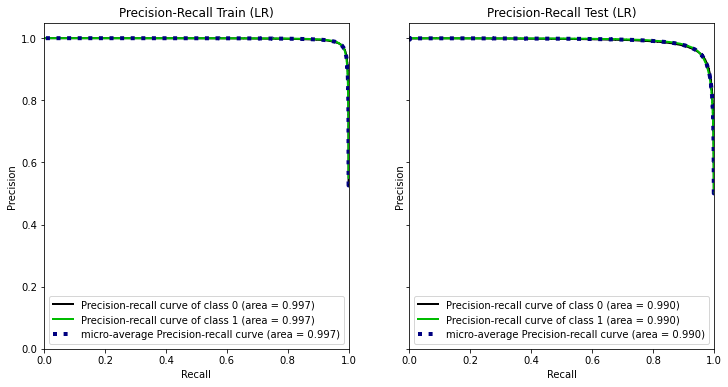

In [30]:
# Plot precision / recall cruve
fig_pr, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_precision_recall(y_train, prob_train, ax=ax[0], title="Precision-Recall Train (LR)")
skplt.metrics.plot_precision_recall(y_test, prob_test, ax=ax[1], title="Precision-Recall Test (LR)")
plt.show()

The Precision-Recall curves above shows that as the threshold changes (and the recall increases) the precision scores remains high. This means that as the threshold changes the classifier continue to return accurate results (high precision), as well as positive results (high recall).

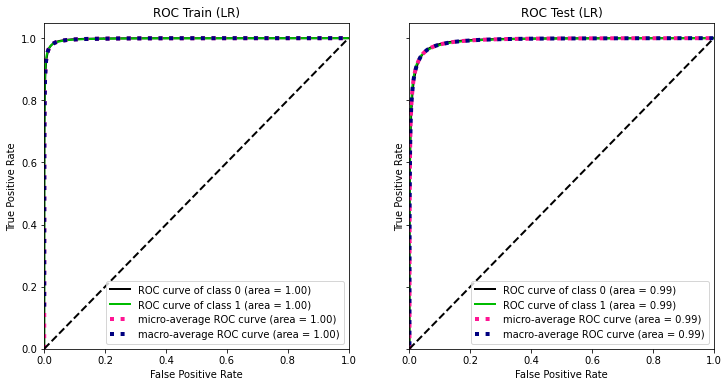

In [31]:
fig_auc, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_roc(y_train, prob_train, ax=ax[0], title='ROC Train (LR)')
skplt.metrics.plot_roc(y_test, prob_test, ax=ax[1], title='ROC Test (LR)')
plt.show()

The ROC curves above shows the the model can accurately discriminate between the different classes, and does not prduce false positives as the threshold increases. This would suggest that there is no overlap between the different classes.

The area indicates that you have good **recall** under all thresholds.

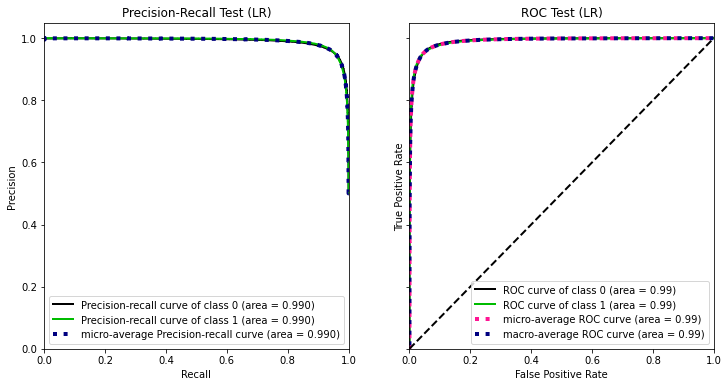

In [32]:
fig_curves, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_precision_recall(y_test, prob_test, ax=ax[0], title="Precision-Recall Test (LR)")
skplt.metrics.plot_roc(y_test, prob_test, ax=ax[1], title='ROC Test (LR)')
plt.show()

The area under the ROC curve tells you how could the model is predicting 1s as 1s and 0s as 0s. The TPR is the Recall and the FPR (FP/FP+TN). Here the model is excellent at correctly predicting the right class at any given threshold. Decreasing threshold increases Recall & FPR. Increasing the threshold does the opposite. So, here as the threshold decreases, the TPR/FPR increase very quickly (until the threshold doesn't matter) this means the model predicting classes with high probability. (The TPR increases at a much faster rate than the FPR as the threshold decreases)

The PR shows how the Precision and Recall scores change for each class as the threshold changes. Here, as the threshold decreases the Recall increases. However, as the predicted probabilities for the classes are so high, the threshold does not impact the precision scores until the point at which the the threshold is almost 0. At which point only perfect TN predictions will remain in place, everything else will move over the positive class.

In [40]:
fig_curves.savefig('model_performance_curves.jpg', bbox_inches='tight')

In [33]:
df_coef = pd.DataFrame(model.coef_[0], index=columns,
                       columns=['coefs'])
df_coef['coef_abs'] = df_coef.coefs.abs()

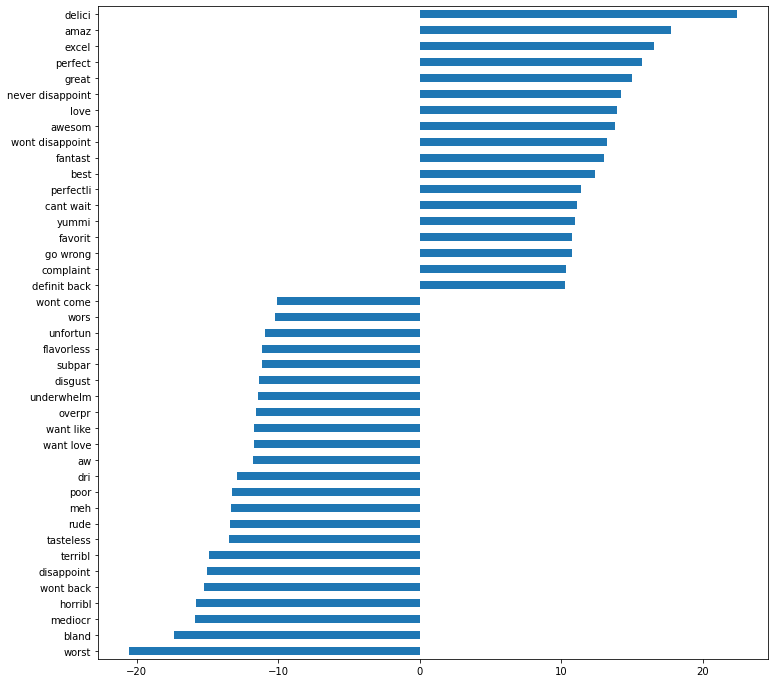

In [34]:
fig_coef, ax = plt.subplots(figsize=(12,12))
df_coef[df_coef.coef_abs > 10]['coefs'].sort_values().plot(kind='barh');

In [43]:
fig_coef.savefig('model_performance_coef.jpg', bbox_inches='tight')

In the coefficient graph above the positive coefficient enhance the prediction of a positive review, while the negative coefficients diminish the chance, and enhance preidcitions of a negative review.

- Positive coefficients enhance the prediction being part of the predictive class. As a coeffiecneit becomes more positive it enhances the chances of an observations being assigned to the predictive class
- Negative coeffcients diminsih the chance of being in the predictive class. As a coefficient becomes more negative it dimished the chance of an observation being assigned to the predictive class.

### 5. Pickle final model

In [12]:
import joblib

In [76]:
# joblib.dump(model, 'yelp_model.jlib')
# joblib.dump(pipe_final, 'yelp_pipe.jlib')

['yelp_pipe.jlib']

In [13]:
model = joblib.load('yelp_model.jlib')
pipe_final = joblib.load('yelp_pipe.jlib')

--- 

## Assess sentiment of chosen restaurant

In [61]:
query = '''
    select review_id, review_year, text, stars 
    from yelp_reviews_filtered 
    where business_id = 'JpgVl3d20CMRNjf1DVnzGA' 
    and review_year > 2018
'''

In [62]:
# load in chosen restaurant data
rest = pd.read_sql(sql=query, con=engine)
rest.head()

,review_id,review_year,text,stars
0,L-eK5AkslHTh7_mk5n0PaA,2019,"we had an excellent meal tonight. our server, ...",5
1,C3jt2j2DfSVaW3UvuIWQKg,2019,worst food ever.. they walk around with burnt ...,1
2,K6AwX8wctGo4xYZIdVSY_w,2019,delicious food and excellent service! all the ...,5
3,fi8LyvMPE74AVchRcL623w,2019,had the worse experience here. service was hor...,1
4,jlYfItUIWYNzAtGun97Hzw,2019,this the most horrible meat i ate in my life. ...,1


In [63]:
rest.shape

(472, 4)

In [64]:
# setup predictors and target
X = pipe_final.transform(rest['text'])
y = rest.stars.apply(lambda x: (x > 3)*1)

In [65]:
X.shape, y.shape

((472, 100000), (472,))

In [66]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: stars, dtype: int64

In [67]:
model.score(X, y)

0.9533898305084746

In [68]:
rest['predictions'] = model.predict(X)

In [69]:
probs = []
for _ in list(model.predict_proba(X)):
    probs.append(float(_[0]))

In [70]:
rest['pred_probs_0'] = probs

In [71]:
rest.head()

,review_id,review_year,text,stars,predictions,pred_probs_0
0,L-eK5AkslHTh7_mk5n0PaA,2019,"we had an excellent meal tonight. our server, ...",5,1,0.005674
1,C3jt2j2DfSVaW3UvuIWQKg,2019,worst food ever.. they walk around with burnt ...,1,0,0.998865
2,K6AwX8wctGo4xYZIdVSY_w,2019,delicious food and excellent service! all the ...,5,1,0.000141
3,fi8LyvMPE74AVchRcL623w,2019,had the worse experience here. service was hor...,1,0,0.999813
4,jlYfItUIWYNzAtGun97Hzw,2019,this the most horrible meat i ate in my life. ...,1,0,0.999801


In [101]:
rest.to_csv('rest_data.csv', index=False)

## Wordclouds for +ve and -ve reviews

In [72]:
freq_words = get_freq_words(X, columns)
freq_words[:20]

meat         19.047640
brazilian    13.974003
pri          11.950291
pampa        11.565457
server       11.503100
servic       11.275169
salad bar    10.943271
food          9.491163
great         8.678389
waiter        8.544796
bar           7.709596
us            7.239670
come          7.112356
experi        7.004545
salad         6.934964
amaz          6.903283
nick          6.868859
time          6.823217
aaron         6.246826
tabl          6.217206
dtype: float64

In [73]:
pos_words = pipe_final.transform(rest[rest.predictions==1]['text'])

In [82]:
# top words for positive reviews
freq_pos_words = get_freq_words(pos_words, columns)
freq_pos_words[:10]

pri          11.865549
meat          8.654342
server        8.347432
pampa         7.977129
great         7.426827
servic        6.837006
amaz          6.383079
aaron         6.246826
nick          6.226551
brazilian     5.934249
dtype: float64

In [96]:
rows = ['pri', 'meat', 'server', 'servic', 'aaron', 'nick', 'food', 'tyler', 'experi', 'salad bar', 'attent', 'waiter', 'time', 'groupon', 'pineappl', 'great servic', 'friendli', 'delici', 'care','unlimit', 'food great']
pos_words_fil = freq_pos_words.loc[rows]

In [75]:
neg_words = pipe_final.transform(rest[rest.predictions==0]['text'])

In [101]:
# top words for negative reviews
freq_neg_words = get_freq_words(neg_words, columns)
freq_neg_words[:10]

meat                   10.393298
brazilian               8.039753
salad bar               6.150112
waiter                  4.514116
servic                  4.438163
bar                     4.381271
salad                   3.917141
tabl                    3.902069
brazilian steakhous     3.811245
food                    3.631329
dtype: float64

In [102]:
rows = ['meat', 'salad bar', 'waiter', 'servic', 'tabl', 'food', 'server', 'time', 'wait', 'coupon', 'fogo', 'voucher', 'manag', 'steak', 'sirloin', 'tough', 'slow', ]
neg_words_fil = freq_pos_words.loc[rows]

In [78]:
from wordcloud import WordCloud

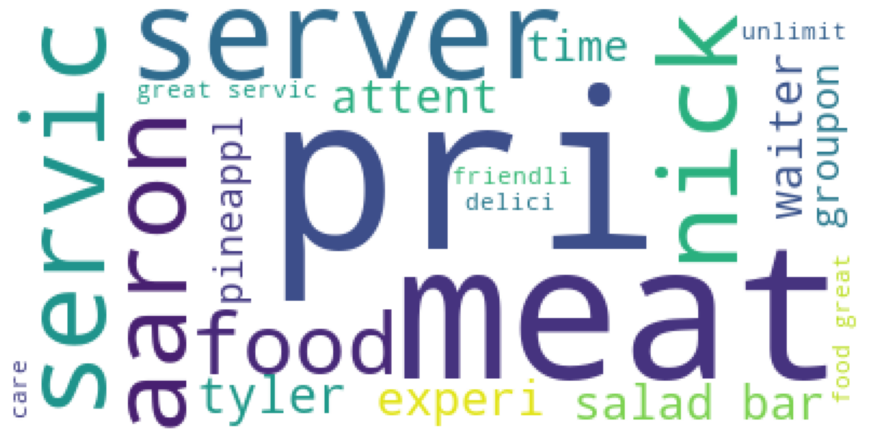

In [100]:
pos_wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(frequencies=pos_words_fil)
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(pos_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

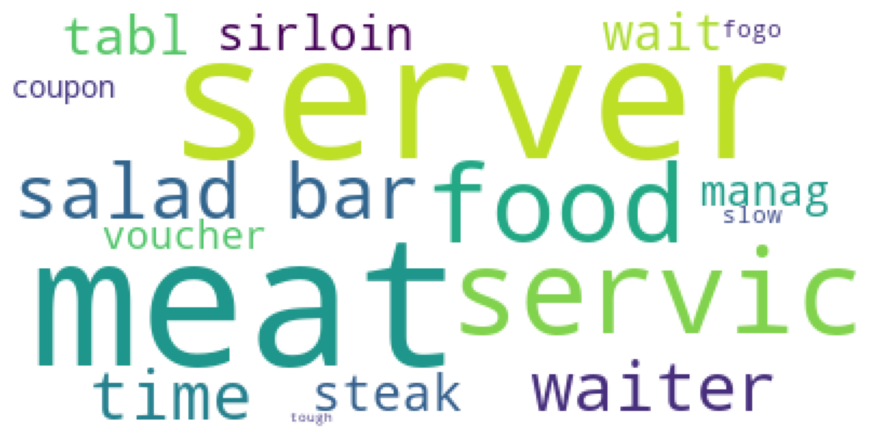

In [103]:
neg_wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(frequencies=neg_words_fil)

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(neg_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

---

### Predictions for all steak resturants

In [17]:
query = '''
    select business_id, review_id, review_year, text, stars 
    from yelp_reviews_filtered 
    where 1=1
    and review_year > 2013
    and business_id in
    (
	'JpgVl3d20CMRNjf1DVnzGA',
	'R_ZlcX46pPdjhjmfd043LA',
	'OETh78qcgDltvHULowwhJg',
	'bpRo8L8dkhgbJhdIKa9mwA',
	'UTXNr62dGSK-tet8OeXUcQ',
	'xkVMIk_Vqh17f48ZQ_6b0w',
	'C9ImzBi5fn742ZcAYDww2A',
	'xVEtGucSRLk5pxxN0t4i6g',
	'ahSFUPojs9X3-1jP-QPb-w',
	'4JNXUYY8wbaaDmk3BPzlWw',
	'SAIrNOB4PtDA4gziNCucwg',
	'GI-CAiZ_Gg3h21PwrANB4Q',
	'I6EDDi4-Eq_XlFghcDCUhw',
	'igHYkXZMLAc9UdV5VnR_AA'
	)
'''

In [18]:
# load all steak restaurant data
all_rest = pd.read_sql(sql=query, con=engine)
all_rest.head()

,business_id,review_id,review_year,text,stars
0,SAIrNOB4PtDA4gziNCucwg,-C4LQIevhfCLZ5mOcZVagA,2019,this is a beautiful hidden local las vegas gem...,5
1,4JNXUYY8wbaaDmk3BPzlWw,Mxcge_WWBU_TO37iPKAgdw,2015,"every time my friends and i go to vegas, dinne...",5
2,GI-CAiZ_Gg3h21PwrANB4Q,Iy_GubuIw0bYk__FKIaoMA,2019,one of my favorite restaurants to go to when i...,5
3,OETh78qcgDltvHULowwhJg,O9JhggESrNAS-y23SUvNPQ,2017,"this steakhouse is all the way through, from ...",5
4,UTXNr62dGSK-tet8OeXUcQ,sXi0mLmgZvZyHk4w9zMTtQ,2015,the best customer service started as soon as w...,5


In [20]:
all_rest.shape

(28687, 5)

In [22]:
# setup predictors and target
X_all = pipe_final.transform(all_rest['text'])
y_all = all_rest.stars.apply(lambda x: (x > 3)*1)

In [23]:
X_all.shape, y_all.shape

((28687, 100000), (28687,))

In [24]:
model.score(X_all, y_all)

0.9311186251612229

In [25]:
all_rest['predictions'] = model.predict(X_all)

In [26]:
probs = []
for _ in list(model.predict_proba(X_all)):
    probs.append(float(_[0]))

In [27]:
all_rest['pred_probs_0'] = probs

In [28]:
all_rest.head()

,business_id,review_id,review_year,text,stars,predictions,pred_probs_0
0,SAIrNOB4PtDA4gziNCucwg,-C4LQIevhfCLZ5mOcZVagA,2019,this is a beautiful hidden local las vegas gem...,5,1,0.001471
1,4JNXUYY8wbaaDmk3BPzlWw,Mxcge_WWBU_TO37iPKAgdw,2015,"every time my friends and i go to vegas, dinne...",5,1,0.000045
2,GI-CAiZ_Gg3h21PwrANB4Q,Iy_GubuIw0bYk__FKIaoMA,2019,one of my favorite restaurants to go to when i...,5,1,0.002282
3,OETh78qcgDltvHULowwhJg,O9JhggESrNAS-y23SUvNPQ,2017,"this steakhouse is all the way through, from ...",5,1,0.001109
4,UTXNr62dGSK-tet8OeXUcQ,sXi0mLmgZvZyHk4w9zMTtQ,2015,the best customer service started as soon as w...,5,1,0.043416


In [30]:
all_rest.to_csv('all_rest_data.csv', index=False)